# Tutorial on DER Management | Operating Envelopes: The Basics

## 1. Introduction 

### Objectives 
The objectives of this tutorial are:
1. To familiarise with the process by which power enginners can calculate operating envelopes to facilitate exports/imports from customers whilst ensuring that voltages and asset utilisation are within the limits. 

2. To continue familiarising with the advanced tool [OpenDSS](https://www.epri.com/pages/sa/opendss) (using Python and the [dss_python](https://github.com/dss-extensions/dss_python) module). And, to guide you, all will be done using a notebook on [Jupyter Notebook](https://jupyter.org/).

### Structure of this Document
The rest of this document is divided into three parts:

- **2. Tutorial.** You will learn how to determine operating envelopes using electrical models to ensure that voltages and asset utilisation are within limits.
- **3. Exercises.** Here you will go through some exercises that will help you familiarise with the code and how to modify it for different purposes.
- **4. Simulation Workspace.** Here you can place all your code to run it at once. You should use **`code`** that is relevant to each question 

<font color='red'>**<u>Note</u>:**</font> Make sure to understand well how to model the operating envelopes, because this will be crucial to go through the exercises. If you make a mistake when modelling the network, your results will be incorrect.

## 2. Tutorial   

We will use the Test LV Circuit (shown in the figure below) from the [Tutorial-DERHostingCapacity-2-TimeSeries_LV](https://github.com/Team-Nando/Tutorial-DERHostingCapacity-2-TimeSeries_LV).  

Since you have already been working with this Test LV Circuit, only the information related to the **operating envelopes** will be given in detail. 

<img style="float: middle;" src="LVcircuit-topology.png" width="50%">  

**<center>Figure 1. Test LV Circuit Topology</center>**   

**Operating Envelopes (OEs)**

To properly understand operating envelopes, it is important to first define two types of distribution network customers:

- **Active Customers**: The ones that engage with aggregators who, in turn, use the customers' DER to provide services to the system operator (AEMO in Australia).
- **Passive Customers**: These are conventional customers. They might have DER but do not engage with aggregators.

<img style="float: middle;" src="Active_Passive_Customers.png" width="70%">

*Passive customers* have **fixed** maximum power exports/imports at their connection point. These fixed limits are defined by the connection agreement with the DNSP and/or by the circuit breaker rating at the site. For instance, a small single-phase house in Australia could have a fixed import limit of 14kW and an export limit of 5kW (common in Australia to mitigate the effects of solar PV).

*Active customers*, on the other hand, will have **time-varying** maximum exports/imports at their connection point. These values will be calculated by the DNSP to ensure network integrity (voltages within the statutory limits and asset have not exceeded their rated capacity). For instance, a single-phase house in a neighbourhood with lots of solar PV could be given an export limit at 1pm of 3kW but at 5pm it could be 10kW.

<img style="float: middle;" src="Operating_Envelops.png" width="40%"> 

**How can DNSPs calculate the OEs?** One approach is to do this calculation using electrical models of the corresponding network. One can explore different values of OEs until the voltage or asset utilisation limits are hit. This is done for exports and imports separately. In addition, one can have different objective functions (or allocation techniques). For more information, check the links below.
- [Deliverable 1.1 "Operating Envelopes Calculation Architecture"](https://www.researchgate.net/publication/348176636_Deliverable_11_Operating_Envelopes_Calculation_Architecture)
- [Deliverable 1.2 "High-level Assessment of Objective Functions"](https://www.researchgate.net/publication/348404040_Deliverable_12_High-level_Assessment_of_Objective_Functions)
- [Project EDGE](https://electrical.eng.unimelb.edu.au/power-energy/projects/project-edge#resources)

**In this Tutorial we will explain how to calculate the Operating Envelopes of 13 out of 31 single-phase customers (i.e., 13 active customers)** such that the voltages and asset utilisation are within the limits. For simplicity, **we will consider that all active customers will have the same operating envelope**, i.e., the calculation will consider that the value is the same for all of them simultaneously. This OE allocation is usually called **equal allocation** or **equal opportunity**. You will also investigate different numbers of active customers in the questions.

Follow the steps below. **And let's begin!**

<font color='red'>**<u>Note</u>:**</font> You will need to run the code in each cell. Select the code cell (a <font color='green'>**green box [ ]**</font> surrounding the cell will appear) and then click on the &#9654; **`Run`** button on top of the page to run the corresponding code (or use the shortcut `Control`-`Enter`). Since you will be running code, **you will need to run the cells sequentially**, one after the other without skipping code cells. A number will appear inside the brackets [X] indicating the number of the *run*.

### 2.1 Load Modules and Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math
import dss
from random import choice

<a id='4'></a>
### 2.2 Set the working path
Run the code in the cell below to get your working path. As an output you get the location of this notebook in your computer.  

<font color='red'>**<u>Note 1</u>:**</font> Your path should not have spaces. Here is an example with no spaces: `C:\Users\student_name\Desktop\ELEN90077_Workshops`.

<font color='red'>**<u>Note 2</u>:**</font> If you are a MAC user, there may be some errors due to the different use of slash/backslash when defining a path. By changing `/` instead of `\`, you will fix the problem. For instance, you can change `\\Residential..` with `/Residential..`.

<font color='red'>**<u>Note 3</u>:**</font> You should always open the Jupyter Notebook file from the folder that you uploaded to Jupyter Notebook. If you want to continue working later, you can simply save the changes and then open the **.ipynb** file again and continue working from where you left.

In [2]:
mydir = os.getcwd()
print(f"The direction is located in the following path: my_directory = {mydir}")

The direction is located in the following path: my_directory = C:\Users\ASIMONOVSKA\Documents\GitHub\Operating-Envelopes


### 2.3 Set up dss_engine

In [3]:
dss_engine = dss.DSS
DSSText = dss_engine.Text
DSSCircuit = dss_engine.ActiveCircuit
DSSSolution = dss_engine.ActiveCircuit.Solution
ControlQueue = dss_engine.ActiveCircuit.CtrlQueue
dss_engine.AllowForms = 0

### 2.4 Network, Load and solar PV Modelling
#### 2.4.1 Define components
The `LVcircuit-master.txt` file defines the frequency and base voltages, then it redirects to network components definitions: transformers, lines, loads, etc.  
<font color='red'>**<u>Note</u>:**</font> Always use the `.dss` and `.txt` files from the current workshop, in this case workshop 5.

In [4]:
DSSText.Command = 'Clear'                               
DSSText.Command = 'Compile ' + mydir +  '\\TestLVCircuit\\LVcircuit-master.txt'    
DSSText.Command = 'Set VoltageBases = [22.0, 0.400]'
DSSText.Command = 'calcvoltagebases'

#### 2.4.2 Import Load and PV profiles and store their shapes

In [5]:
houseData30minutes = np.load(mydir + '\\TestLVCircuit\\Residential load data 30-min resolution.npy') 
PVData30minutes = np.load(mydir + '\\TestLVCircuit\\Residential PV data 30-min resolution.npy')

In [6]:
shape_profiles  = houseData30minutes.shape
noProfiles = shape_profiles[0]
PV_shape_profiles  = PVData30minutes.shape

x=[i for i in range(48)]
l=[]
for i in range(24): 
      l.append("%s:00"%i)
      l.append(" ")

### 2.5 Definition of Functions

#### 2.5.1 def <font color=blue> Load_profile_allocation</font> (New,icust,cust,iday)

In [7]:
def Load_profile_allocation(New,icust,cust,iday):
    if New==1:
       load_profile = np.zeros(48)
       DSSCircuit.LoadShapes.New('customer_profile_%s' %(icust))
       DSSCircuit.LoadShapes.Npts = 48
       DSSCircuit.LoadShapes.MinInterval = 30
       DSSCircuit.LoadShapes.UseActual = 1
       reactive_profile = (load_profile * math.tan(math.acos(0.95))).tolist()
       reactive_profile=np.array(reactive_profile)
    
    if New==0:
        random_profile = np.random.randint(0,noProfiles)        
        load_profile = houseData30minutes[random_profile, iday, :]
        reactive_profile = []
        for j in range(48):
            reactive_profile.append((load_profile[j]) * math.tan(math.acos(0.95)))
        reactive_profile = np.array(reactive_profile)          
        DSSCircuit.LoadShapes.Qmult = reactive_profile.tolist()
        
        
    DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(icust)
    DSSCircuit.LoadShapes.Pmult = load_profile.tolist()
    DSSCircuit.LoadShapes.Qmult = reactive_profile.tolist()
    DSSCircuit.SetActiveElement('load.%s'%(cust))
    DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(icust))
    if New==0:
        return (load_profile,reactive_profile,random_profile)

#### 2.5.2 def <font color=blue> PV_allocation</font> (New,icust,cust,iday)

In [8]:
def PV_allocation(New,icust,cust,iday):
    if New==1:
        PV_profile = np.zeros(48)
        DSSCircuit.LoadShapes.New('pv_profile_%s' %(icust))
        DSSCircuit.LoadShapes.Npts = 48
        DSSCircuit.LoadShapes.MinInterval = 30
        DSSCircuit.LoadShapes.UseActual = 1
        DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()
        DSSCircuit.SetActiveElement('load.%s' %(cust))
        bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
        DSSText.Command = 'new PVSystem.%s'%(icust)\
                                + ' phases = 1'  \
                                + ' irradiance = 1' \
                                + ' %cutin = 0.05' \
                                + ' %cutout = 0.05' \
                                + ' vmaxpu = 1.5' \
                                + ' vminpu = 0.5' \
                                + ' kva = 10' \
                                + ' pmpp = 10'\
                                + ' bus1 = ' + str(bus_name)\
                                + ' pf = 1' \
                                + ' kv = 0.23' \
                                + ' daily = ' +str('pv_profile_%s'%(icust))
    else:
        PV_profile = PVData30minutes[iday,:]
        pv_profiles_all.append(PV_profile)        
        DSSCircuit.LoadShapes.Name = 'pv_profile_%s' %(icust)
        DSSCircuit.LoadShapes.Pmult = PV_profile.tolist()        
        DSSCircuit.SetActiveElement('load.%s' %(cust))
        bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
        DSSCircuit.SetActiveElement('PVSystem.%s'%(icust))
        DSSCircuit.ActiveElement.Properties('bus1').Val = str(bus_name)
        DSSCircuit.ActiveElement.Properties('daily').Val = str('pv_profile_%s'%(icust))
        return PV_profile

#### 2.5.3 def <font color=blue>Initiate_variable</font> (customers)

In [9]:
def Initiate_variable(customers):
    kW_monitors = np.zeros((customers,48))
    kvar_monitors = np.zeros((customers,48))
    voltages_monitors = np.zeros((customers,48))
    df_kw = pd.DataFrame()
    df_kvar = pd.DataFrame()
    df_volt = pd.DataFrame()
    load_profiles_all = []
    pv_profiles_all = []
    random_profiles_all = []    
    rand_cust = []  
    reactive_profiles_all = []
    return  (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, 
             df_volt, load_profiles_all, pv_profiles_all, random_profiles_all, rand_cust,reactive_profiles_all)

#### 2.5.4 def <font color=blue>Monitors_data</font> ()

In [10]:
def Monitors_data():
    for icust, cust in enumerate(Loadname):
            DSSCircuit.SetActiveElement('load.%s' %(cust))
            kW_monitors[icust, itime] = DSSCircuit.ActiveElement.Powers[0]
            kvar_monitors[icust,itime]= DSSCircuit.ActiveElement.Powers[1]
            bus_name = DSSCircuit.ActiveElement.Properties('bus1').Val
            DSSCircuit.SetActiveBus(bus_name)
            voltages_monitors[icust, itime] = DSSCircuit.ActiveBus.VMagAngle[0]

### 2.6 Simulation 
#### 2.6.1  Set simulation period
- Set `start_day` and `total_day` to choose the simulation period you want.  
- You will run the simulation only for `start_day=220`, so **you should not change this code block** at all.

In [11]:
start_day = 220
total_days = 1

#### 2.6.2 Set the Type of Customers
In this totorial we will use the following configuration: 
 1. **Active Customers** (13/31, 42% of the customers)
 2. **Passive Customers without DER** (16/31, 52% of the customers)
 3. **Passive Customers with DER** (2/31, 6% of the customers)
 
- The sum of the active and passive custumers should always give the total number of customers, in this case 31 single-phase customers.
- You can notice that in OpenDSS, each load starts with **load_mg1_`Number-Cust`**, where `Number-Cust` is the number of the load/customer.   
<font color='red'>**<u>Note</u>:**</font> You will have to change the configuration as given in the questions! 

In [12]:
active_customers=['load_mg1_1', 'load_mg1_2', 'load_mg1_9', 'load_mg1_13','load_mg1_22','load_mg1_24', 
                    'load_mg1_25','load_mg1_26','load_mg1_27','load_mg1_28', 'load_mg1_29',  'load_mg1_30', 'load_mg1_31' ]

passive_customers_noDER=[  'load_mg1_3', 'load_mg1_4', 'load_mg1_5','load_mg1_6', 'load_mg1_7', 'load_mg1_10',  
                         'load_mg1_11','load_mg1_12', 'load_mg1_14','load_mg1_15', 'load_mg1_16', 'load_mg1_17', 
                         'load_mg1_18', 'load_mg1_19', 'load_mg1_20','load_mg1_23']

passive_customers_DER=['load_mg1_8', 'load_mg1_21']

#### 2.6.3 Initialise Load profiles and PV systems
After defining the functions, we are ready to allocate the Load and PV profiles.

In [13]:
Loadname = DSSCircuit.Loads.AllNames
customers=len(Loadname)
icust_DER_passive=list(range(0,(len(passive_customers_DER))))
temp=0
for icust, cust in enumerate(Loadname):
    Load_profile_allocation(1,icust,cust,0)  
    PV_allocation(1,icust,cust,0)
    if cust in passive_customers_DER: 
        icust_DER_passive[temp]=icust
        temp=temp+1           

### 2.7 Defining Operating Envelopes and Power Flow Analysis

Since the operating envelopes are time-varying **export/import** limits at the network connection point of the `active customers`, you will run the simulation to find the maximum exports and maximum imports **separately**.    
You will have to select between **1** and **2**, depending which **operating envelopes you are going to define**. 
- To define the **maximum exports**, use **OE=1**, which in the code will use the values for exports **`(OE_values_exports)`**. These values have **negative (-)** sign. 
- To define the **maximum imports**, use **OE=2**, which in the code will use the values for imports **`(OE_values_imports)`**. These values have **positive (+)** sign.

<font color='red'>**<u>Note</u>:**</font> Both **`OE_values_exports`** and **`OE_values_imports`** are arrays of 48 values (in kW), corresponding to 48 time-periods in the day (because of the 30-min time resolution that is used for the whole day).
- The **OEs are the same** for `all active customers` for the given time period. For instance, if we take time-period=24 (equivalent to 12:00h), if the OE value is -6, then all active customers have 6kW as maximum export at that time period. They can have another value for 15:00h, for instance -7, which means all active cutomers at time peiod 30 (equivalent to 15:00h) will have 7kW as maximum export.


#### 2.7.1 How do you change the values for the maximum exports?
- First, you need to select **OE=1**, since you are going to use the **exports**. 
- Then, after running the code block, you need to check if **voltages** and **asset utilisation** are within the limits. 
    1. You will notice that the voltages are **above** the statutory limits by:
         - Looking at the voltage profiles plot, where voltages exceed the top red dashed line, 
         - By running `print(df_volt[time_step])` in a separate code block to get all customers' voltages for the specific time period (time period values are in range from 0 to 47), or
         - By running `print(df_volt)` to get all customers' voltages for all 48 time periods at once. 
   2. The thermal limits will not be affected in this case. If they were affected a message such as "This is time: `time-period`, There is a thermal violation of the line `line-name`" will be printed.
   
For the given configuration:   
- Since for time period 0 (equivalent to 00:00h) the voltage is above the limits for many customers, you should change the value of the OE.  
- Then, you run the simulation again and if the voltage is still above the limits, you change the value of the OE again until all customers are compliant. 
- When the voltages with the new value for the OE are within the limits, the value for the OE for that time period is said to be defined. 
- Once the value for the OE is defined for the specific time period, you move on to the next time period untill you define all time periods of the day (48 in total). 
- In the end the **`OE_values_exports`** array will contain new values for the OEs that you have defined that ensure voltage and thermal assets compliance. 

#### 2.7.2 How do you change the values for the maximum imports?
- Same as changing the values of the exports with some modifications:
    - First, you need to select **OE=2**, since you are going to use the **imports**. 
    - Then, if you run the code block you need to check for any **voltage** of **thermal limits** violations.
      1. You will notice that the voltages are **below** the statutory limits by:
         - Looking at the voltage profiles plot, where voltages are below the bottom red dashed line, 
         - By running `print(df_volt[time_step])` in a separate code block to get all customers' voltages for the specific time period (time period values are in range from 0 to 47), or
         - By running `print(df_volt)` to get all customers' voltages for all 48 time periods at once. 
   2. The thermal limits **will be affected** in this case. You will get the following message "This is time: `time-period`, There is a thermal violation of the line `line-name`" for each time period for at least one line. 
   
For the given configuration:   
- Since for time period 0 (equivalent to 00:00h) the voltage is within the limits, however the thermal limits are not, therefore you need to change the value of the OE.
- Then, you run the simulation again and if the thermal limits are still violated, you change the value of the OE again until there are no thermal issues. 
- When you no longer get a printed message for the 0 time period, the value for the OE for that time period is said to be defined. 
- Once the value for the OE is defined for the specific time period, you move on to the next time period untill you define all time periods of the day (48 in total). 
- In the end the **`OE_values_imports`** array will contain new values for the OEs that you have defined that ensure voltage and thermal assets compliance.    

This is day:  220
Message: The Solution Converged Successfully



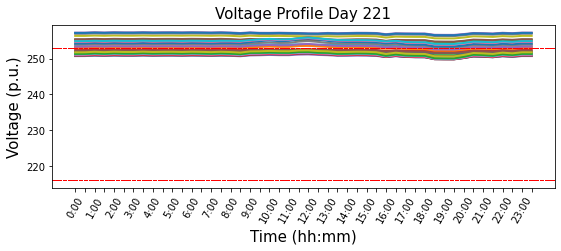

In [14]:
OE=1  # 1 or 2 

for iday in range(start_day,start_day+total_days):
    print("This is day: ",iday)
    np.random.seed(10)
    (kW_monitors, kvar_monitors, voltages_monitors, df_kw, df_kvar, df_volt, 
     load_profiles_all, pv_profiles_all, random_profiles_all, rand_cust,reactive_profiles_all) = Initiate_variable(customers)
    
    OE_values_exports=[-10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10,  #00:00 to 6AM
                       -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10,  #6:30AM to 12PM
                       -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10,  #12PM to 6PM
                       -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10]  #6PM to 23:30
    
    OE_values_imports=[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  #00:00 to 6AM
                      14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  #6:30AM to 12PM
                      14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  #12PM to 6PM
                      14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]  #6PM to 23:30
    
    new_load_profile=np.zeros(48)
    for i in range(48):
        if OE==1:
            new_load_profile[i]=OE_values_exports[i]
        elif OE==2: 
            new_load_profile[i]=OE_values_imports[i]
          
    for icust, cust in enumerate(Loadname):
        if cust in active_customers:
            DSSCircuit.LoadShapes.Name = 'customer_profile_%s' %(icust)
            DSSCircuit.LoadShapes.Pmult = new_load_profile.tolist()
            DSSCircuit.SetActiveElement('load.%s'%(cust))
            DSSCircuit.ActiveElement.Properties('daily').Val = str('customer_profile_%s' %(icust))
        else:
            load_profile,reactive_profile,random_profile=Load_profile_allocation(0,icust,cust,iday)
            load_profiles_all.append(load_profile)
            reactive_profiles_all.append(reactive_profile)
            random_profiles_all.append(random_profile)
            np.random.seed(90)
        
    for numb in range(len(passive_customers_DER)):
         temp=icust_DER_passive[numb]   
         PV_allocation(0,numb,passive_customers_DER[numb],iday)
        
    DSSText.Command = 'Reset'       
    DSSText.Command = 'Set Mode=daily  number=1 stepsize=30m' 
    save_input_oe_voltage_lv_hof=np.zeros((3,48))    
    for itime in range(48):
        DSSSolution.Solve()
        line_names = DSSCircuit.Lines.AllNames
        lv_oe_line_list = []
        for iLine in range(len(line_names)):
            lv_oe_line_list.append(line_names[iLine])     
        Monitors_data()
        
        # verify thermal limits of lines
        lv_hof_util_f0 = 0
        keep_thermal_lines_perc_3f=[]
        keep_thermal_lines_perc_1f=[]
        for iLine in range(len(lv_oe_line_list)):
            DSSCircuit.SetActiveElement('line.' + str(lv_oe_line_list[iLine]))
            number_phases_lines = int(DSSCircuit.ActiveElement.Properties('phases').Val)
            if number_phases_lines == 3:
                I11 = DSSCircuit.ActiveCktElement.CurrentsMagAng[0]
                I12 = DSSCircuit.ActiveCktElement.CurrentsMagAng[2]
                I13 = DSSCircuit.ActiveCktElement.CurrentsMagAng[4]
                I_rated = DSSCircuit.Lines.NormAmps
                I_max_lv_oe_temp = max(I11, I12, I13)
                keep_thermal_lines_perc_3f.append((I_max_lv_oe_temp/I_rated)*100)
                if I_max_lv_oe_temp > I_rated:
                    flag_thermal_line = 0
                    print("This is time: %s,There is a thermal violation of the line %s "%(itime,lv_oe_line_list[iLine]))
                    break
                else:
                    flag_thermal_line = 1
            else:
                I11 = DSSCircuit.ActiveCktElement.CurrentsMagAng[0]
                I_rated = DSSCircuit.Lines.NormAmps
                keep_thermal_lines_perc_1f.append((I11/I_rated)*100)
                if I11 > I_rated:
                    flag_thermal_line = 0
                    print("This is time: %s,There is a thermal violation of the line %s "%(itime,lv_oe_line_list[iLine]))
                    break
                else:
                    flag_thermal_line = 1
                    
         # verify thermal limits of transformer
        DSSCircuit.SetActiveElement('transformer.transformer_MG1_TR1')
        lv_oe_tx_power_capacity = 500
        lv_oe_tx_amp_capacity_phase = (500/3)/0.433
        number_phases = int(DSSCircuit.ActiveElement.Properties('phases').Val)
        if number_phases == 3:
            I1_LVT = DSSCircuit.ActiveCktElement.CurrentsMagAng[8]
            I2_LVT = DSSCircuit.ActiveCktElement.CurrentsMagAng[10]
            I3_LVT = DSSCircuit.ActiveCktElement.CurrentsMagAng[12]
            if (I1_LVT + I2_LVT + I3_LVT) > (3 * lv_oe_tx_amp_capacity_phase):
                flag_thermal_tx = 0
                print("Themal issues at the transformer")
            else:
                flag_thermal_tx = 1
                lv_tx_util = 100 * (I1_LVT + I2_LVT + I3_LVT) / (3 * lv_oe_tx_amp_capacity_phase)
    df_kw=pd.DataFrame(kW_monitors)
    df_kvar=pd.DataFrame(kvar_monitors)
    df_volt=pd.DataFrame(voltages_monitors)    
    
    if DSSSolution.Converged:
         print('Message: The Solution Converged Successfully\n')
    else:
         print("Message: The Solution Did Not Converge\n") 
           
    fig=plt.figure(figsize=(9,3)) 
    for idx, row in df_volt[0:31].iterrows():
             plt.plot(np.array(row), linewidth = 2)         
             plt.xlabel("Time (hh:mm)", fontsize = 15)
             plt.xticks(fontsize = 10)
             plt.xticks(x,l, fontsize=10, rotation=60)
             plt.ylabel('Voltage (p.u.)', fontsize = 15)
             plt.yticks(fontsize = 10)
             plt.title("Voltage Profile Day %s"%(iday+1), fontsize = 15)
             plt.axhline(253, linewidth = 1,linestyle='dashed', color = 'r')
             plt.axhline(216, linewidth = 1,linestyle='dashed', color = 'r')
            
    plt.show()
    

#### 2.7.3 Plot the Operating Envelopes
Once you define the values for the OEs for exports and imports for all time periods, you can plot the final OEs. 

<font color='red'>Note </font> that there will not be a straight line. Here it is because all values are the same for all time periods, which is not the case for the active customers. 

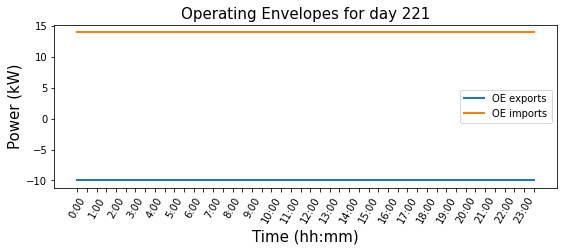

In [15]:
fig=plt.figure(figsize=(9,3)) 
plt.plot(OE_values_exports, linewidth = 2, label='OE exports')  
plt.plot(OE_values_imports, linewidth = 2, label='OE imports')  
plt.xlabel("Time (hh:mm)", fontsize = 15)
plt.xticks(fontsize = 10)
plt.xticks(x,l, fontsize=10, rotation=60)
plt.ylabel('Power (kW)', fontsize = 15)
plt.yticks(fontsize = 10)
plt.title("Operating Envelopes for day %s"%(iday+1), fontsize = 15)
plt.legend()

## 3. Exercises

First, read all the exercises so you understand their purpose.

At the very end of this notebook in **4. Simulation Workspace**, you will be able to place all your code to run it at once. Remember, you should use **`code`** that is relevant to each exercise.

### **Exercise 1: Define Operating Envelopes with 42% active customers**

In this exercise you will use the `Test LV Circuit` as in the Tutorial with the **exact same configuration** for the active and passive customers.

Use the exact day as given in the tutorial: `select_day=220` and do not change it.

**E1:** Considering exports, what is the operating envelope for the selected day? Assume that the maximum export value per customer is 10kW (due to the rated capacity of the DER behind the meter). Explore values in steps of 1kW. 

**E2:** Considering imports, what is the operating envolope for the selected day? Assume that the maximum import value per customer is 14kW (common value for single-phase houses). Explore values in steps of 1kW.


## 4. Simulation Workspace